# Get train and test datasets to analysis
Собираю датасет для проверки различных гипотез и оценки вклада фич в результат


In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost
import matplotlib.pyplot as plt


dataset_path = './train/train_dataset.csv'

scaler_columns = [
                    'StateHolidayDays',
                    'SchoolHolidayDays',
                    'Sales',
                    'PromoDays',
                    'Promo2DaysToNext',
                    'Promo2AllDays',
                    'Promo2Days',
                    'MeanByDay',
                    'Mean',
                    'DayOfWeek',
                    'DayOfMonth',
                    'Customers',
                    'CompetitionDistance',
                    'CompetitionDays'
                ]
encoder_columns = [
                    'Assortment',
                    'StateHoliday',
                    'StoreType'
                ]

df = pd.read_csv(dataset_path, sep=',', index_col=False)

Создаем объекты MinMaxScaler для числовых признаков, OneHotEncoding - для категориальных признаков

In [2]:
def get_minmaxscaler(df, columns):
    scalers = []
    for column_name in columns:
        scaler = MinMaxScaler().fit(df[column_name].values.reshape(-1, 1))
        scalers.append((column_name, scaler))
    return scalers

def get_encoder():
    objects = ['a', 'b', 'c', 'd', '0']
    l_enc = LabelEncoder()
    l_enc.fit(objects)
    labels = l_enc.transform(objects).reshape(-1, 1)
    oh_enc = OneHotEncoder(sparse=False, categories='auto')
    oh_enc.fit(labels)
    return l_enc, oh_enc
        
def get_processing_objects(df):
    scalers = get_minmaxscaler(df, scaler_columns)
    l_enc, oh_enc = get_encoder()
    return scalers, l_enc, oh_enc

scalers, l_enc, oh_enc = get_processing_objects(df)

Получаем для дальнейшей работы обучающую и тестовую выборки

In [3]:
def get_train_and_test_datasets(df, scalers, l_enc, oh_enc, ratio=0.9):
    x = pd.DataFrame()

    index = 0
    # Числовые признаки
    for s in scalers:
        print(f'{s[0]} - {index}')
        x[f'{index}'] = s[1].transform([df[s[0]].values])[0]
        index += 1
    # Категориальные признаки
    for column_name in encoder_columns:
        cat = l_enc.transform(df[column_name].values)
        labels = oh_enc.transform(cat.reshape((-1, 1)))
        for i in range(0, labels.shape[1]):
            print(f'{column_name} - {index}')
            x[f'{index}'] = pd.Series(labels[:,i])
            index += 1
    # Остальные признаки - добавляем "как есть"
    columns = list(df.columns.values)
    for del_column in (scaler_columns + encoder_columns):
        columns.remove(del_column)
    for add_column in columns:
        print(f'{add_column} - {index}')
        x[f'{index}'] = df[add_column]
        index += 1
    # Делим на тестовую и обучающую выборки - Sales имеет индекс 2
    y = x['2']
    del x['2']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-ratio, random_state=123)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_train_and_test_datasets(df, scalers, l_enc, oh_enc)

StateHolidayDays - 0
SchoolHolidayDays - 1
Sales - 2
PromoDays - 3
Promo2DaysToNext - 4
Promo2AllDays - 5
Promo2Days - 6
MeanByDay - 7
Mean - 8
DayOfWeek - 9
DayOfMonth - 10
Customers - 11
CompetitionDistance - 12
CompetitionDays - 13
Assortment - 14
Assortment - 15
Assortment - 16
Assortment - 17
Assortment - 18
StateHoliday - 19
StateHoliday - 20
StateHoliday - 21
StateHoliday - 22
StateHoliday - 23
StoreType - 24
StoreType - 25
StoreType - 26
StoreType - 27
StoreType - 28
DayAfterClose - 29
Open - 30
Promo - 31
Promo2 - 32
Promo2Active - 33
SchoolHoliday - 34
Store - 35


Выявляем значимые признаки

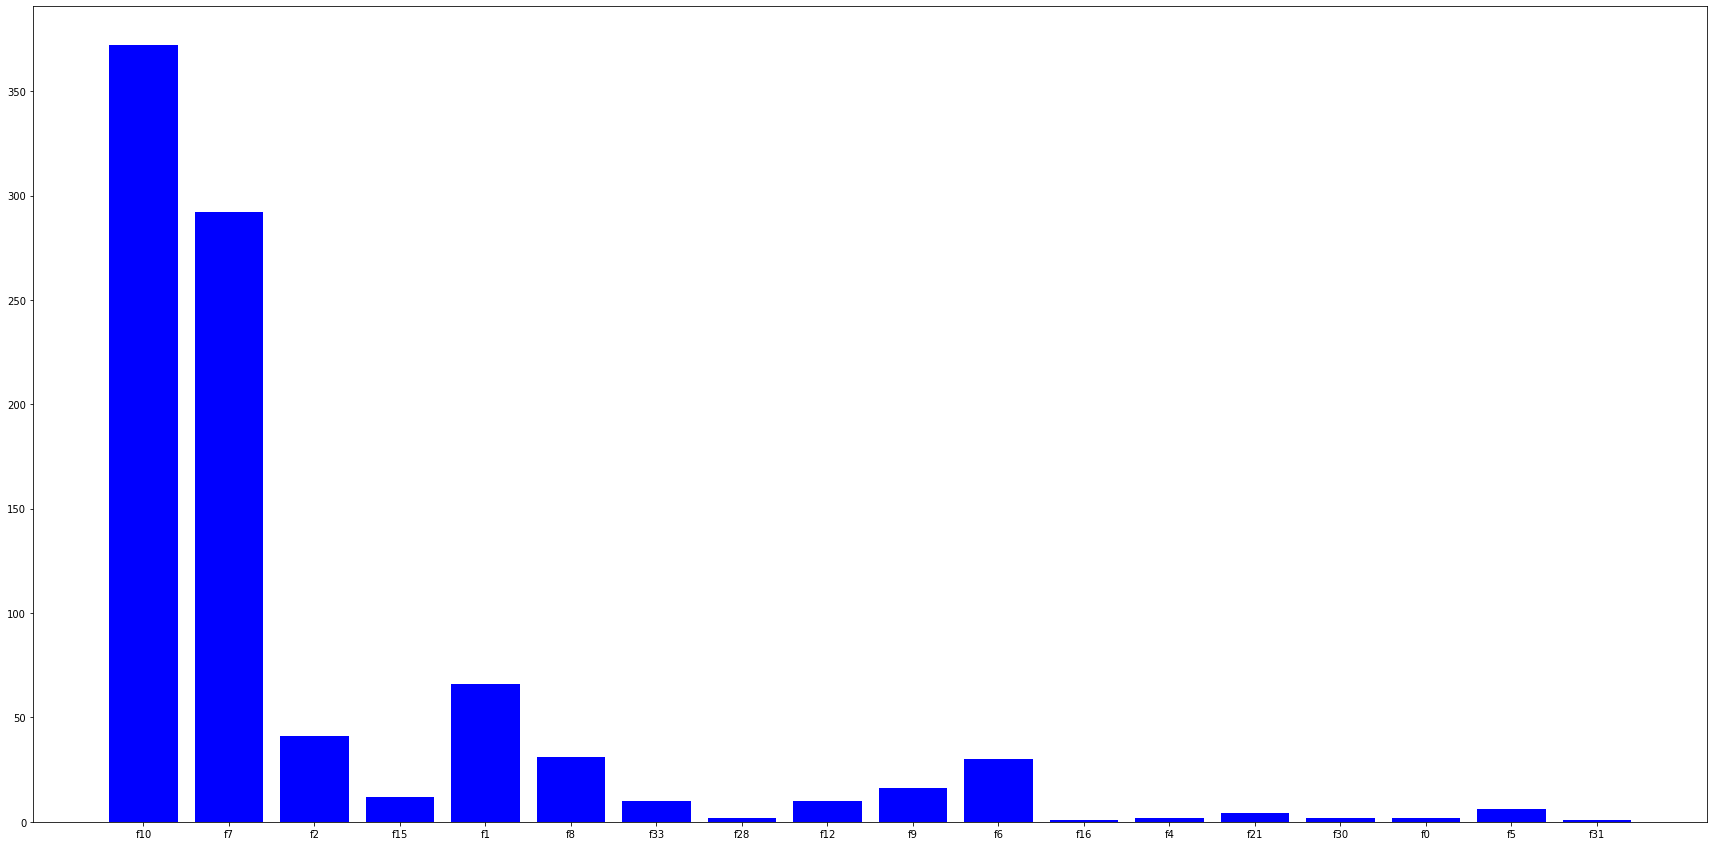

In [4]:
def get_feature_analyze_gb_model(x_train, y_train):
    gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=2, n_estimators=300, subsample=1, learning_rate=0.05, seed=300)
    gbm.fit(x_train.values, y_train.values)
    imps = gbm.get_booster().get_fscore()
    plt.figure(figsize=(30, 15))
    plt.bar(imps.keys(), imps.values(), color='b')
    plt.show()
    
get_feature_analyze_gb_model(x_train, y_train)

In [4]:
fit_column = ['11', '8', '3', '16', '1', '9', '34', '13', '10', '7', '6']

# Fit
Начинаем обучать, параметры learning_rate и estimators делаем изменяемыми, строим график ошибки от этих значений, подбираем лучшие параметры

In [ ]:
def fit(x_train, y_train, x_test, y_test, fit_column):
    errors = []
    y = scalers[2][1].inverse_transform([y_test.values])
    for seed in [300, 305]:
        for e in range(1000, 3200, 200):
            print(f'seed: {seed}, estimators: {e}')
            gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=8, n_estimators=e, subsample=1, learning_rate=0.005, seed=seed)
            gbm.fit(x_train[fit_column].values, y_train.values)
            # Тест
            y_pred = gbm.predict(x_test[fit_column].values)
            y2 = scalers[2][1].inverse_transform(y_pred.reshape(1, -1))
            errors.append({'mse': mean_squared_error(y[0], y2[0]), 'estimators': e, 'seed': seed})
    return pd.DataFrame.from_dict(errors)

errors_stat = fit(x_train, y_train, x_test, y_test, fit_column)

seed: 300, estimators: 1000
seed: 300, estimators: 1200
seed: 300, estimators: 1400
seed: 300, estimators: 1600
seed: 300, estimators: 1800
seed: 300, estimators: 2000
seed: 300, estimators: 2200
seed: 300, estimators: 2400
seed: 300, estimators: 2600
seed: 300, estimators: 2800
seed: 300, estimators: 3000
seed: 305, estimators: 1000
seed: 305, estimators: 1200
seed: 305, estimators: 1400
seed: 305, estimators: 1600
seed: 305, estimators: 1800
seed: 305, estimators: 2000
seed: 305, estimators: 2200
seed: 305, estimators: 2400
seed: 305, estimators: 2600
seed: 305, estimators: 2800
seed: 305, estimators: 3000


Анализируем полученные результаты

In [6]:
print(errors_stat.loc[errors_stat[['mse']].idxmin(), :])

   estimators            mse  seed
1         600  564218.848866   300


Строим графики зависимости ошибки от всех подбираемых параметров модели

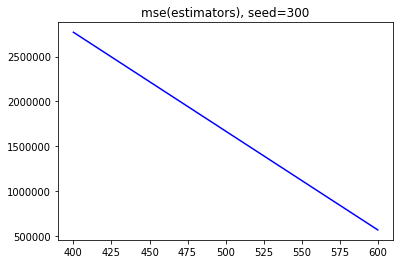

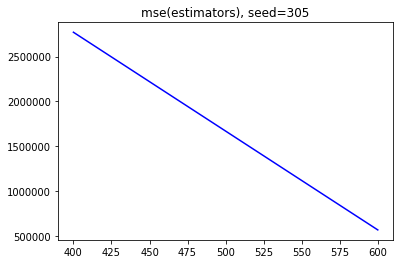

In [7]:
def visualisation(x, y, title):
    plt.figure()
    plt.plot(x, y, color='b')
    plt.title(title)
    plt.show()

visualisation(errors_stat[errors_stat['seed'] == 300]['estimators'], errors_stat[errors_stat['seed'] == 300]['mse'], 'mse(estimators), seed=300')
visualisation(errors_stat[errors_stat['seed'] == 305]['estimators'], errors_stat[errors_stat['seed'] == 305]['mse'], 'mse(estimators), seed=305')